In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score

In [2]:
ENCRYPTED_DIRECTORY = "data/govdocs_encrypted"
PLAINTEXT_DIRECTORY = "data/govdocs_plaintext"

In [3]:
def load_data(directory):
    dataframes = list()
    for f in glob.glob(f"{directory}/**.csv.gz"):
        if os.path.exists("temp.csv"):
            os.remove("temp.csv")
        if os.path.exists("temp.csv.gz"):
            os.remove("temp.csv")
        os.system(f"cp {f} temp.csv.gz")
        os.system(f"gunzip temp.csv.gz")
        df = pd.read_csv("temp.csv")
        dataframes.append(df)
    return pd.concat(dataframes).copy()

df_plaintext = load_data(PLAINTEXT_DIRECTORY)
df_plaintext["is_encrypted"] = 0
df_encrypted = load_data(ENCRYPTED_DIRECTORY)
df_encrypted["is_encrypted"] = 1

master_df = pd.concat([df_plaintext, df_encrypted])

# Shuffle
master_df = master_df.sample(frac=1).reset_index(drop=True)

# Filter out only webp
master_df = master_df[master_df['extended.extension'] != '.webp']
#print("only webp: ", master_df.shape)

# Filter out files which are larger than 4k
master_df = master_df[master_df['baseline.filesize'] > 512]
#print("greater than 4096: ", master_df.shape)

# The dataframe may be fragmented, so we create a copy here
master_df = master_df.copy()

print("Before dropping nans", master_df.shape)
# fill Nan with 0
master_df['baseline.chisquare_end'] = master_df['baseline.chisquare_end'].fillna(0.0)
master_df.dropna(inplace=True)
print("After dropping nans", master_df.shape)


Before dropping nans (97759, 528)
After dropping nans (88260, 528)


In [4]:
columns_to_consider = []
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
#columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']
columns_to_consider += [c for c in master_df.columns if c.startswith("fourier.stat")]
columns_to_consider += [c for c in master_df.columns if c.startswith('baseline')]
columns_to_consider += [c for c in master_df.columns if "kurtosis" in c or "skew" in c]
columns_to_consider.append('is_encrypted')


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
#X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
#X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

#X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [5]:
rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(y_test, y_pred)}")
print(f"accuracy = {accuracy_score(y_test, y_pred)}")

[0.77384684 0.77385321] [0.77802792 0.76961679] [0.77593175 0.77172919] [4442 4384]
F1 = 0.7717291857273559
accuracy = 0.7738499886698391


[0.07678782 0.01469409 0.04907758 0.0508411  0.0146128  0.02195394
 0.19326738 0.10488567 0.05236115 0.01564749 0.0137539  0.03213716
 0.0158509  0.06221586 0.12480361 0.02802797 0.01356954 0.01673439
 0.01217103 0.03016128 0.0165503  0.02770516 0.01218987]


<BarContainer object of 23 artists>

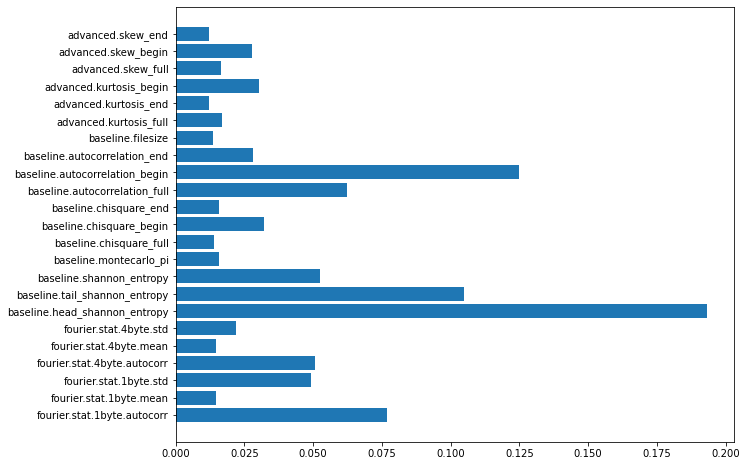

In [8]:
#df1 = master_df[X_train.isna().any(axis=1)]
#print(df1)
#print(X_train.describe().T)
plt.rcParams["figure.figsize"] = (10, 8)
print(rfc.feature_importances_)
plt.barh(X_train.columns, rfc.feature_importances_)